<a href="https://colab.research.google.com/github/guillermohenrion/Social-Network-Analytics/blob/master/An%C3%A1lisis_de_texto_y_redes_en_tweet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Análisis de tópicos y de redes en Twitter 

### Paso 1: Dar de alta app en twitter

Nota: Se necesita usuario twitter

[Twitter Apps](https://developer.twitter.com/en/apps)


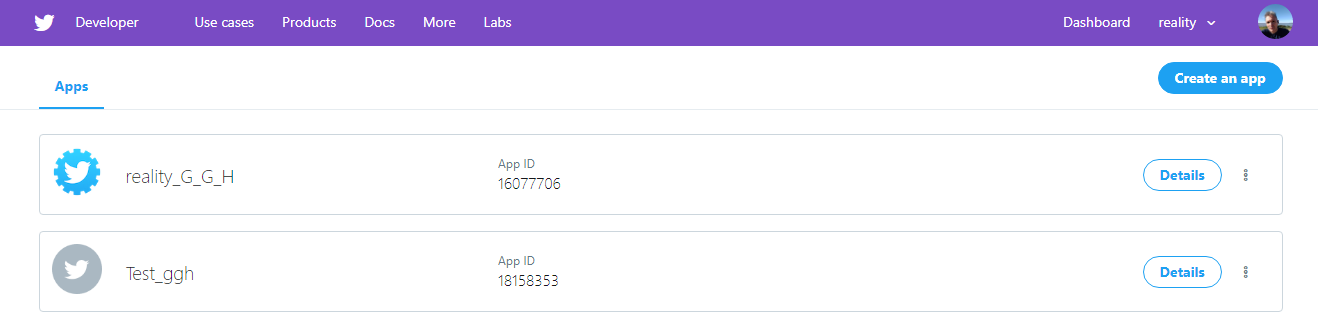

Nota: Poner opción student y una url de website válido (sino usar https://guillermo-henrion.webnode.com/)

Poner en texto de uso por ejemplo: "I am interested in conducting a study analyzing how information flows among the participating individuals, under what conditions they expand and under which they stagnate. If we look at this dynamic and recognize it as a complex adaptive system, where information flows. This analysis aims to respond to how we consume and influence the information since someone publishes it until we see it and replicate it."

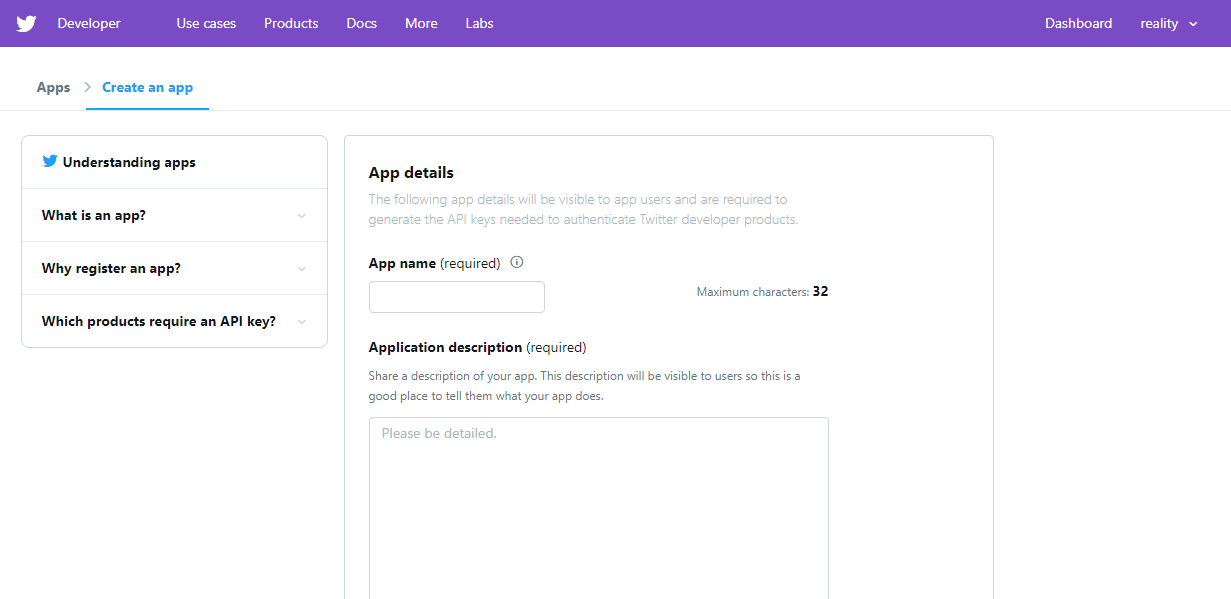

Genrar API key y Acccess token

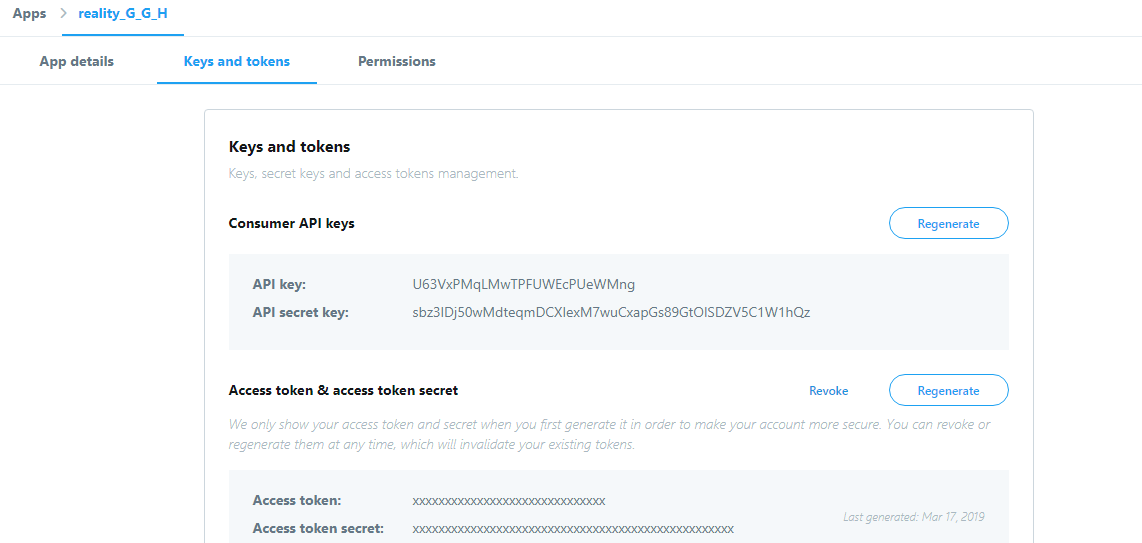

###Paso 2: Instalar las librerías y componentes, e importar librerías

Nota: Se necesita reiniciar en entorno de ejecución luego de la instalación 

In [147]:
!pip install twython
!pip install ftfy
!pip install pyLDAvis
!python -m spacy download es_core_news_sm
!python -m spacy download fr_core_news_sm
import nltk
nltk.download('stopwords')

✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_sm')
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [148]:
from twython import Twython
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from os import path
import matplotlib.pyplot as plt
import os
import random
import pandas as pd
import ftfy
import re
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import gensim
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
import os
from gensim.models.wrappers import LdaMallet, ldamallet
from gensim.corpora import Dictionary
import spacy
import pyLDAvis.gensim
import csv
from unicodedata import normalize
import string
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 

###Paso 3: Conectar a la app Twitter

In [149]:
SEED = 8888

from spacy.lang.en.stop_words import STOP_WORDS

twitter = Twython("U63VxPMqLMwTPFUWEcPUeWMng", "sbz3lDj50wMdteqmDCXIexM7wuCxapGs89GtOlSDZV5C1W1hQz",
                    "280807268-MgZfUIUEb1vkPehfjB8sfuicMstiw0Afek49kkNL", "g8QammrsFv1zHfWrGtypSkNloEx1tmU2IpzRaW6JJNjIX")
# API key, APIsecret key, Access token, Access token secret

#twitter2= Twython("1MBA20oxA5BiYqRaSjMN3oqYe","faLpEuitVadZAKZMYqtJwdMVrpLlZkLhtNOW94YsGsAfXwcadn",
#"280807268-mVB5Lz2MTRC7rUTNoIa3HF34LFyE6qGNQAkUPLVM","paviGM8YU6t0cTQlMUS8j1dysgcva1drWSA8J3tJJ2w2G")

twitter.sleep_on_rate_limit = True


###Paso 4: definir funciones varias (ej. preprocessing para convtertir texto a lista de palaras para construir el bow en donde cada docuemnto está representado como una lsita de palabras)

In [150]:
######################################################################################################################
# Funciones
######################################################################################################################

def sacarURL(t):
    p=re.compile('<a [^>]*>')
    p2=re.compile('</a>')
    r=re.sub(p, '', t)
    r=re.sub(p, '', t)
    r=re.sub(p, '', t)
    r=re.sub(p2, '', r)
    r=re.sub(p2, '', r)
    r=re.sub(p2, '', r)
    return r


def preprocessing(text,stopwords):
    text = text.lower()  # texto a minúsculas
    text = re.sub(r'\[.*?¿\]%', ' ', text)  # Se remueven corchetes
    text = re.sub(r'\(.*?¿\)%', ' ', text)  # Se remueven parentesis
    text = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', text)  # Se remueven signos de puntuación
    text = re.sub(r'\w*\d\w*', '', text)  # Se remueven palabras que contienen dígitos.
    text = re.sub(r'\n', ' ', text)  # Sustituye nueva línea por un espacio
    text = re.sub(r'\s+', ' ', text, flags=re.I)  # Sustituye los múltiples espacios por sólo un espacio
    text = re.sub(r'[‘’“”…«»°*_/¿¡!?]', '', text)  # Remueve otros caracteres no sintácticos
    text = re.sub(r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+|\u20AC", r"\1",
                  normalize("NFD", text), 0, re.I)  # NFD y eliminar diacríticos y símbolo euro
    text = normalize('NFC', text)  # NFC
    bigram_list = bigram[text.split()]
    out_text = lemmatization(' '.join(bigram_list), allowed_postags=['NOUN'])  # ,'VERB','ADJ', 'PROPN'
    text_non_stop = [word for word in out_text if word not in stopwords]

    return text_non_stop

def lemmatization(texts, allowed_postags=None):
    if allowed_postags is None:
        allowed_postags = ['NOUN']
    texts_out = [token.lemma_ for token in nlp(texts) if token.pos_ in allowed_postags]
                 #allowed_postags and token.text not in black_list and len(token.text) > 2]
    return texts_out


def display_topics(model, model_type='lda'):
    for topic_idx, topic in enumerate(model.print_topics()):
        print('Topic %d:' % topic_idx)
        if model_type == 'hdp':
            print(" ".join(re.findall(r'\*(.[^\*-S]+).?', topic[1])), '\n')
        else:
            print(" ".join(re.findall(r'\"(.[^"]+).?', topic[1])), '\n')

def format_topics_sentences(ldamodel=0, corpus=[], texts=0):
    sent_topics_df = pd.DataFrame()  # - n

    # Tema principal en cada documento
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Tema dominante, porcentaje de contribución y palabras claves
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # Tema dominante
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(
                    pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Agrega el texto original al final
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df


###Paso 5: Traer tweets a analizar 

In [151]:
tweetdf=pd.DataFrame([], columns=['id', 'text'])

for i in range(0,5):

    user_tweets = twitter.get_user_timeline(screen_name='alferdez', #EmmanuelMacron #leopoldolopez
                                            include_rts=True, count=1000, tweet_mode="extended")

    for tweet in user_tweets:
        tweet['text'] = Twython.html_for_tweet(tweet)
        new_row={'id':tweet['id'], 'text':sacarURL(tweet['text'])}
        tweetdf=tweetdf.append(new_row, ignore_index=True)

tweetdf.count()

id      1000
text    1000
dtype: int64

###Paso 6: definir funciones varias (ej. preprocessing para convtertir texto a lista de palaras para construir el bow en donde cada docuemnto está representado como una lsita de palabras)

Representación vectorial de documentos en espacio de palabras

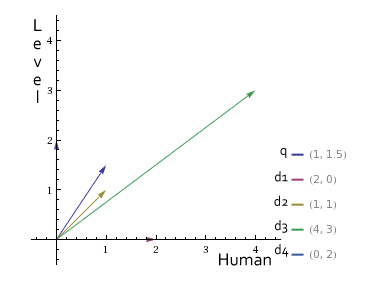

Preprocesamiento

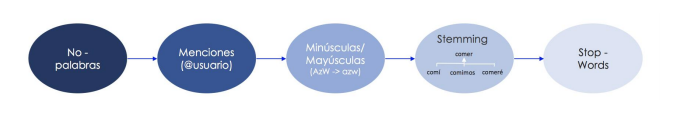

###Paso 7: Definir stopwords en español, nlp en español también (nlp permite lemmatizacion, part of speech tag, etc.) y bigramas

In [152]:
# Palabra a ignorar junto a los stop words

black_list = ['garcia', 'hashtag', 'span', 'twitter_com', 'suffix_twitter', 'n', 'q', 'eh', 'me', 'xq', 'z', 'x', 'etc', 'd', 'm', 's', 'u', 'p', 'l', 'as', 'av', 'j', 'porq', 'c',
              'v', 'cdo', 'i', 'unas', 'k', 't', 'pq', 'b', 'g', 'ne', 'r', 'h', 'qu', 'f', 'co', 'ud', 'sta', 'srta',
              'sr', 'sra', 'srita', 'tb', 'osea', 'po', 'ala', 'ami', 'ka', 'mo', 'migo', 'lis', 'in', 'idas', 'asique',
              'aunq', 'miy', 'lla', 'unlam', 'na', 'don', 'xxxx', 'yla', 'qie', 'qur', 'qye', 'fu', 'my', 'ke', 'laa',
              'll', 'mm', 'tmb', 'pr', 'ay', 'or', 'nc', 'xk', 'xx', 'ye', 'rn', 'hr', 'eramos', 'estabamos', 'estais',
              'estan', 'estara', 'estaran', 'estaras', 'estare', 'estareis', 'estaria', 'estariais', 'estariamos',
              'estarian', 'estarias', 'esteis', 'esten', 'estes', 'estuvieramos', 'estuviesemos', 'fueramos',
              'fuesemos', 'habeis', 'habia', 'habiais', 'habiamos', 'habian', 'habias', 'habra', 'habran', 'habras',
              'habre', 'habreis', 'habria', 'habriais', 'habriamos', 'habrian', 'habrias', 'hayais', 'hubieramos',
              'hubiesemos', 'mas', 'mia', 'mias', 'mio', 'mios', 'seais', 'sera', 'seran', 'seras', 'sere', 'sereis',
              'seria', 'seriais', 'seriamos', 'serian', 'serias', 'si', 'tambien', 'tendra', 'tendran', 'tendras',
              'tendre', 'tendreis', 'tendria', 'tendriais', 'tendriamos', 'tendrian', 'tendrias', 'teneis', 'tengais',
              'tenia', 'teniais', 'teniamos', 'tenian', 'tenias', 'tuvieramos', 'tuviesemos', 'vez']

In [153]:
stopwords = nltk.corpus.stopwords.words('spanish')
#stopwords = nltk.corpus.stopwords.words('french')
stopwords.extend(black_list )


In [154]:
# Nlp en idioma español

nlp = spacy.load('es_core_news_sm')
#nlp = spacy.load('fr_core_news_sm')

In [155]:
text='Esta es una sentencia con el fin de probar nlp. Otros fines no se propone.'
print([token.lemma_ for token in nlp(text)])
print([token.pos_ for token in nlp(text)])
print([token.lemma_ for token in nlp("sentencia")])

['Esta', 'ser', 'uno', 'sentenciar', 'con', 'el', 'fin', 'de', 'probar', 'nlp', '.', 'Otros', 'finar', 'no', 'se', 'proponer', '.']
['PRON', 'AUX', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'VERB', 'PROPN', 'PUNCT', 'DET', 'NOUN', 'ADV', 'PRON', 'VERB', 'PUNCT']
['sentenciar']


In [156]:
bigram = gensim.models.Phrases(tweetdf.text.to_list(), min_count=5, threshold=2.0)
tweetdf['text_orig'] = tweetdf['text']  # Resguardamos original
tweetdf['text'] = tweetdf['text'].apply(preprocessing, args=(stopwords, ))


/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


###Paso 8: Definir el bag of word

####Forma sencilla: Representación como espacios vectoriales

Nota: Se pueden contar las aparciones de las palabras o armar indicadores como el TFIDF

In [157]:
# Corpus y diccionario para gensim
dictionary = Dictionary(tweetdf['text'].to_list())
dictionary.compactify()
# Filtrado de extremos
dictionary.filter_extremes(no_below=2, no_above=0.97, keep_n=None)
dictionary.compactify()

corpus = [dictionary.doc2bow(text) for text in tweetdf['text'].to_list()]



###Paso 9: Construir los modelos de extracción de tópicos (lsi y lda)

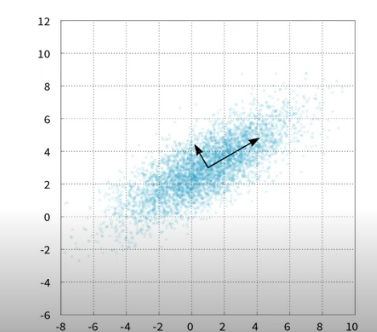

In [158]:
lsimodel = LsiModel(corpus=corpus, num_topics=5, id2word=dictionary)

#print(lsimodel.get_topics())
display_topics(lsimodel)
lsimodel.get_topics()

Topic 0:
presidente empresa argentino telefenoticias pais trabajar dia pandemia compromiso default 

Topic 1:
argentino presidente empresa compromiso pandemia gracia dia pais economia salud 

Topic 2:
empresa presidente provincia trabajar desarrollar gracia default intervencion dia pandemia 

Topic 3:
alumno gracia argentino bandera pais jurar compromiso empresa lealtad partir 

Topic 4:
trabajar pandemia trabajador argentino economia gracia plan empresa gente dia 



array([[ 0.25784596,  0.09515192,  0.03343097, ...,  0.03372365,
         0.01686183,  0.00152536],
       [ 0.61734977,  0.26493132,  0.06479114, ...,  0.03535787,
         0.01767894,  0.00555326],
       [-0.03018061,  0.09210349,  0.020319  , ..., -0.01713094,
        -0.00856547,  0.0027462 ],
       [ 0.34798875, -0.14325184, -0.0922321 , ...,  0.0046074 ,
         0.0023037 ,  0.00089208],
       [-0.25792797, -0.06534372,  0.01658551, ...,  0.01456064,
         0.00728032,  0.01267066]])

In [159]:
vectorized_corpus = lsimodel[corpus] 
display_topics(lsimodel)
print(vectorized_corpus[0])
tweetdf.text[0]



Topic 0:
presidente empresa argentino telefenoticias pais trabajar dia pandemia compromiso default 

Topic 1:
argentino presidente empresa compromiso pandemia gracia dia pais economia salud 

Topic 2:
empresa presidente provincia trabajar desarrollar gracia default intervencion dia pandemia 

Topic 3:
alumno gracia argentino bandera pais jurar compromiso empresa lealtad partir 

Topic 4:
trabajar pandemia trabajador argentino economia gracia plan empresa gente dia 

[(0, 0.761645243037549), (1, 1.6683073358549985), (2, 0.17013149228225433), (3, 0.1926633239451944), (4, 0.2456098135475416)]


['eligalcorta',
 'implementacion',
 'politicas',
 'materia',
 'generar',
 'diversidad',
 'despues',
 'pandemia',
 'compromiso',
 'derecho',
 'mujer',
 'personar',
 'lgbti',
 'argentino']

In [160]:
corpus_predict = dictionary.doc2bow(['presidente', 'empresa', 'argentino', 'telefenoticias', 'pais', 'trabajar', 'dia', 'pandemia', 'compromiso', 'default']) 
vectorized_corpus_predict = lsimodel[corpus_predict] 
print(vectorized_corpus_predict[0])

corpus_predict = dictionary.doc2bow(['presidente', 'empresa', 'argentino', 'telefenoticias', 'gracia', 'economia', 'dia', 'salud', 'compromiso', 'pais']) 
vectorized_corpus_predict = lsimodel[corpus_predict] 
print(vectorized_corpus_predict)



(0, 2.1449469401026655)
[(0, 2.004353937131051), (1, 1.0671817622704745), (2, 0.6192801525865862), (3, -0.20977347112135686), (4, -0.3627502742837689)]


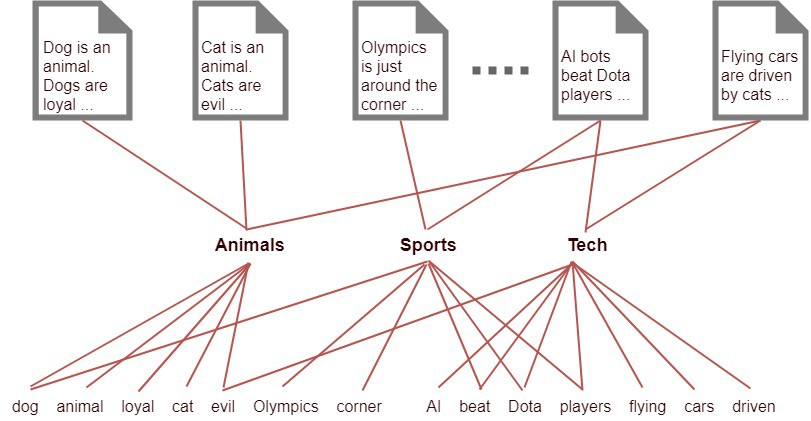

In [161]:
ldamodel = LdaModel(corpus=corpus, num_topics=5, id2word=dictionary)

display_topics(ldamodel)
ldamodel.print_topics(5, 5)


/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

Topic 0:
presidente gracia dia argentino provincia compromiso radiar pandemia default cuidarnos 

Topic 1:
presidente empresa argentino pandemia partir vida soberania bandera salud plantar 

Topic 2:
presidente gobernador pais empresa pandemia alumno conferenciar prensar radiar trabajador 

Topic 3:
presidente argentino trabajar alferdez ciudad pandemia sociedad problema salud mundo 

Topic 4:
presidente telefenoticias empresa economia argentino problema terminos gente radiar lugar 



[(0,
  '0.039*"presidente" + 0.028*"gracia" + 0.022*"dia" + 0.022*"argentino" + 0.021*"provincia"'),
 (1,
  '0.027*"presidente" + 0.026*"empresa" + 0.020*"argentino" + 0.014*"pandemia" + 0.013*"partir"'),
 (2,
  '0.041*"presidente" + 0.021*"gobernador" + 0.020*"pais" + 0.020*"empresa" + 0.018*"pandemia"'),
 (3,
  '0.046*"presidente" + 0.019*"argentino" + 0.015*"trabajar" + 0.013*"alferdez" + 0.012*"ciudad"'),
 (4,
  '0.041*"presidente" + 0.031*"telefenoticias" + 0.026*"empresa" + 0.018*"economia" + 0.017*"argentino"')]

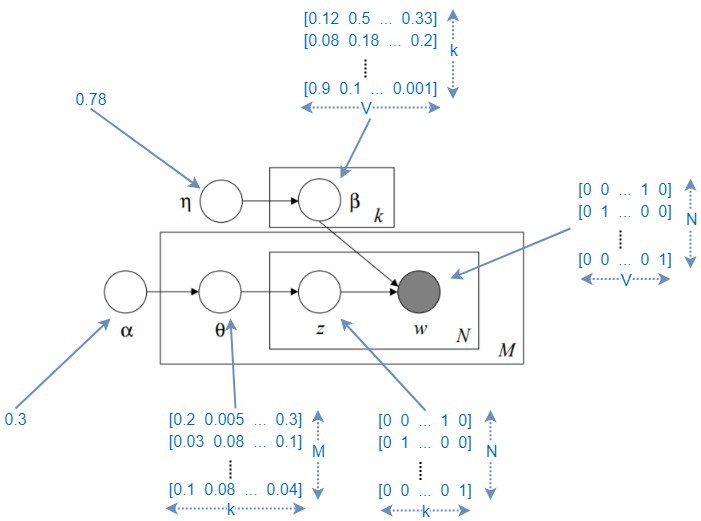

In [162]:

lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [163]:
corpus_predict = dictionary.doc2bow(['dia' ,'gracia' ,'cuidarnos' ,'presidente' ,'reino' ,'argentino' ,'pais' ,'hombre' ,'democracia' ,'pie']) 
print(ldamodel.inference([corpus_predict]))

lda_display = pyLDAvis.gensim.prepare(ldamodel, [corpus_predict], dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

(array([[9.183394  , 0.2044006 , 0.20301011, 0.20595677, 0.20323731]],
      dtype=float32), None)


###Paso 10: Medir la coherencia de los tópcios

In [164]:
cm = CoherenceModel(model=lsimodel, texts=tweetdf['text'].to_list(), dictionary=dictionary, coherence='c_v')
cm.get_coherence()

0.4291668673805072

In [228]:
#def evaluar_hiperparametros(dictionary, corpus, texts, limit, model):

def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=k, 
                                       alpha=a,
                                       eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
   
    return coherence_model_lda.get_coherence()

In [290]:
min_topics = 2
max_topics = 10
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
alpha = list(np.arange(0.01, 1, 0.3))
#alpha.append('symmetric')
#alpha.append('asymmetric')
beta = list(np.arange(0.01, 1, 0.3))
#beta.append('symmetric')

cv_list=[]
for k in topics_range:
    for a in alpha:
        for b in beta:
            cv_list.append([k, a, b, compute_coherence_values(corpus=corpus, dictionary=dictionary, k=k, a=a, b=b)])

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a diff

In [305]:
cv=pd.DataFrame(cv_list)
cv.columns=['k','alpha', 'eta', 'umass']
cv.head()
cvk=cv.groupby(['k']).mean()['umass']
cvk.plot()

min=cv['umass'].min()
k=cv[cv['umass']==min]['k']
alpha=cv[cv['umass']==min]['alpha']
eta=cv[cv['umass']==min]['eta']

52    0.01
Name: eta, dtype: float64

In [306]:
lda_model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=5, 
                                       alpha=0.31,
                                       eta=0.01)


/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

Topic 0:
presidente argentino dia gracia empresa pandemia compromiso pais mujer provincia 

Topic 1:
presidente radiar telefenoticias trabajar empresa bandera ciudad economia plan problema 

Topic 2:
empresa presidente emergencia gracia expropiacion ingresar junio intervencion provincia procesar 

Topic 3:
argentino bit caso pandemia provincia periodista historia distanciar interesar tiempo 

Topic 4:
pandemia compromiso caminar presidente alferdez argentino empresa pais radiar trabajar 



In [309]:
display_topics(lda_model)

lda_display = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

Topic 0:
presidente argentino dia gracia empresa pandemia compromiso pais mujer provincia 

Topic 1:
presidente radiar telefenoticias trabajar empresa bandera ciudad economia plan problema 

Topic 2:
empresa presidente emergencia gracia expropiacion ingresar junio intervencion provincia procesar 

Topic 3:
argentino bit caso pandemia provincia periodista historia distanciar interesar tiempo 

Topic 4:
pandemia compromiso caminar presidente alferdez argentino empresa pais radiar trabajar 



In [310]:
lda_model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=4, 
                                       alpha=0.31,
                                       eta=0.01)

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [311]:
display_topics(lda_model)

lda_display = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

Topic 0:
presidente trabajar gracia telefenoticias empresa provincia economia pandemia radiar dia 

Topic 1:
empresa argentino presidente alferdez tiempo partir democracia bandera caminar trabajador 

Topic 2:
presidente argentino dia gobernador prensar conferenciar vivir distanciar sur medir 

Topic 3:
argentino pais pandemia dia trabajador gracia mujer radiar compromiso economia 



###Paso 11: Construir nube de palabras

In [168]:
text=''
tweetdf['text'][0].sort()
for word in tweetdf['text']:
    wc=' '.join(word)
    text = text+' '+wc;

wordcloud = WordCloud().generate(text)

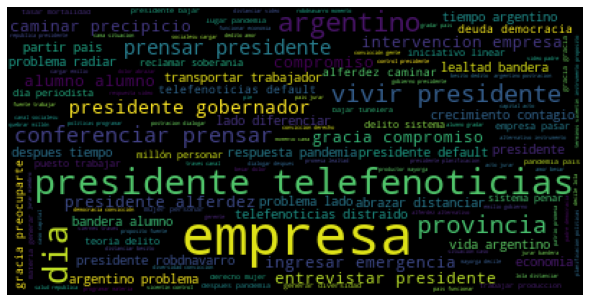

In [170]:
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 


# Análisis de redes

In [172]:
user_tweets = twitter.get_user_timeline(user_id='280807268',
                                        include_rts=True, count=10, tweet_mode="extended")
follow=twitter.get_followers_list(screen_name='alferdez', count=5)['users']

[Quién es quién](https://drive.google.com/file/d/1fxYj7QuBHATLNPRRYKWcI33Xm8S9zv0e/view?usp=sharing)

* 2 Políticos de este gobierno
* 3 Políticos del gobierno anterior
* 1 Filósofo
* 2 Músicos
* 1 Actiz


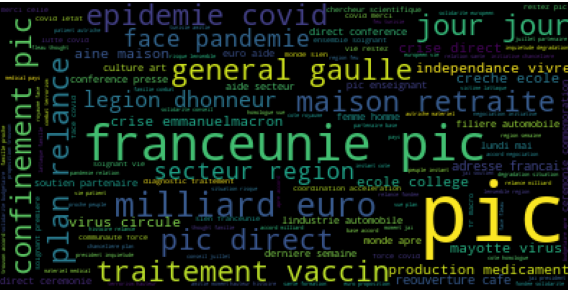

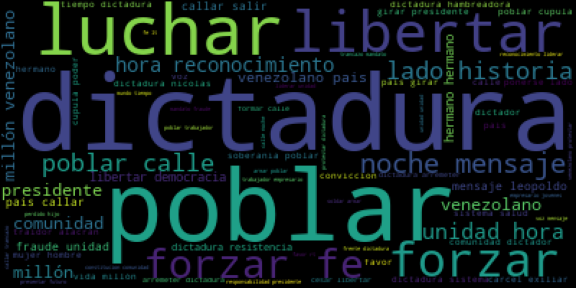